# Library install

In [ ]:
## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode
!pip install matplotlib>=3.3.2

## Install NeMo

!pip install nemo_toolkit[all]

# and restart colab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
sox is already the newest version (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!pip install huggingface-hub==0.23.2


In [ ]:
# 驗證安裝
import nemo
import nemo.collections.asr as nemo_asr

print("NeMo 安裝成功！")

NeMo 安裝成功！


## Audio preprocessing test


In [ ]:
import torchaudio
import os

# 下載 LibriSpeech 數據集
librispeech_data_path = './LibriSpeech'
if not os.path.exists(librispeech_data_path):
    os.makedirs(librispeech_data_path)

# 加載 train-clean-100 部分
train_clean_100 = torchaudio.datasets.LIBRISPEECH(librispeech_data_path, url='train-clean-100', download=True)

# 查看數據集樣本
for i in range(3):
    waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_clean_100[i]
    print(f"Sample {i+1}:")
    print(f"Waveform: {waveform.shape}")
    print(f"Sample Rate: {sample_rate}")
    print(f"Utterance: {utterance}")
    print(f"Speaker ID: {speaker_id}")
    print(f"Chapter ID: {chapter_id}")
    print(f"Utterance ID: {utterance_id}\n")

100%|██████████| 5.95G/5.95G [04:04<00:00, 26.1MB/s]


Sample 1:
Waveform: torch.Size([1, 225360])
Sample Rate: 16000
Utterance: CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK
Speaker ID: 103
Chapter ID: 1240
Utterance ID: 0

Sample 2:
Waveform: torch.Size([1, 255120])
Sample Rate: 16000
Utterance: THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF THE OLD CUTHBERT PLACE IT WAS REPUTED TO BE AN INTRICATE HEADLONG BROOK IN ITS EARLIER COURSE THROUGH THOSE WOODS WITH DARK SECRETS OF POOL AND CASCADE BUT BY THE TIME IT REACHED LYNDE'S HOLLOW IT WAS A QUIET WELL CONDUCTED LITTLE STREAM
Speaker ID: 103
Chapter ID: 1240
Utterance ID: 1

Sample 3:
Waveform: torch.Size([1, 223120])
Sample Rate: 16000
Utterance: FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RACHEL LYNDE'S DOOR WITHOUT DUE REGARD FOR DECENCY AND DECORUM IT PROBABLY WAS CONSCIOUS THAT MISSUS RACHEL WAS SITTING AT HER WINDOW KEEPING A SHARP

[NeMo W 2024-11-03 13:35:24 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
      warnings.warn(
    


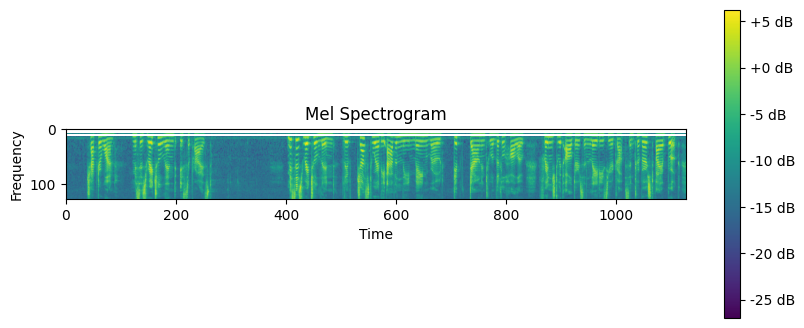

In [ ]:
import matplotlib.pyplot as plt
import torchaudio.transforms as transforms

# 提取 Mel 頻譜特徵
waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_clean_100[0]
mel_spectrogram = transforms.MelSpectrogram(sample_rate=sample_rate)(waveform)

# 顯示 Mel 頻譜
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram.log2()[0,:,:].detach().numpy(), cmap='viridis')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

## ASR, or Automatic Speech Recognition
- recognize the words in the sound

In [ ]:
import os
data_root = ''

Use an4 dataset

In [ ]:
import glob
import os
import subprocess
import tarfile
import wget

an4_url = 'https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz'
an4_path = wget.download(an4_url, data_root)

# follow the instruction, convert .sph to wav by sox
tar = tarfile.open(an4_path)
tar.extractall(path=data_root)

sph_list = glob.glob(data_root + 'an4/**/*.sph', recursive=True)
for sph_path in sph_list:
    wav_path = sph_path[:-4] + '.wav'
    cmd = ["sox", sph_path, wav_path]
    subprocess.run(cmd)


## Use Nemo built-in model

In [ ]:
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2024-11-03 13:39:26 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2024-11-03 13:39:26 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2024-11-03 13:39:26 common:924] Instantiating model from pre-trained checkpoint
[NeMo I 2024-11-03 13:39:28 features:289] PADDING: 16


[NeMo W 2024-11-03 13:39:29 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/core/connectors/save_restore_connector.py:571: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

[NeMo I 2024-11-03 13:39:29 save_restore_connector:249] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


- Inference with pretrained model

In [ ]:
import os
files = [os.path.join(data_root, 'an4/wav/an4test_clstk/fcaw/an406-fcaw-b.wav')]

for fname, transcription in zip(files, quartznet.transcribe(paths2audio_files=files)):
  print(f"Audio in {fname} was recognized as: {transcription}")


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2024-11-03 13:39:29 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/collections/asr/parts/preprocessing/features.py:417: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast(enabled=False):
    


Audio in an4/wav/an4test_clstk/fcaw/an406-fcaw-b.wav was recognized as: rabelt g m e f three nine


## Data prepare for training
- need to change to compatible manifest
- Use well used preprocessing way to do on the A4N

In [ ]:
# --- Building Manifest Files --- #
import json
import librosa

# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_root, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')


train_transcripts = os.path.join(data_root + 'an4/etc/an4_train.transcription')
train_manifest = os.path.join(data_root + 'an4/train_manifest.json')

build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')

test_transcripts = os.path.join(data_root + 'an4/etc/an4_test.transcription')
test_manifest = os.path.join(data_root + 'an4/test_manifest.json')

build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')


[NeMo W 2024-11-03 13:39:29 nemo_logging:349] <ipython-input-23-c0e9fbfbc1e5>:22: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
    	This alias will be removed in version 1.0.
      duration = librosa.core.get_duration(filename=audio_path)
    


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load config
- It a yaml
create a yaml and paste the content below

In [ ]:
"""
name: &name "QuartzNet15x5"
sample_rate: &sample_rate 16000
repeat: &repeat 1
dropout: &dropout 0.0
separable: &separable true
labels: &labels [" ", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
         "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "'"]

model:
  train_ds:
    manifest_filepath: an4/train_manifest.json
    sample_rate: 16000
    labels: *labels
    batch_size: 32
    trim_silence: True
    max_duration: 16.7
    shuffle: True
    num_workers: 8
    pin_memory: true
    # tarred datasets
    is_tarred: false
    tarred_audio_filepaths: null
    shuffle_n: 2048
    # bucketing params
    bucketing_strategy: "synced_randomized"
    bucketing_batch_size: null

  validation_ds:
    manifest_filepath: an4/test_manifest.json
    sample_rate: 16000
    labels: *labels
    batch_size: 32
    shuffle: False
    num_workers: 8
    pin_memory: true

  preprocessor:
    _target_: nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor
    normalize: "per_feature"
    window_size: 0.02
    sample_rate: *sample_rate
    window_stride: 0.01
    window: "hann"
    features: &n_mels 64
    n_fft: 512
    frame_splicing: 1
    dither: 0.00001
    stft_conv: false

  spec_augment:
    _target_: nemo.collections.asr.modules.SpectrogramAugmentation
    rect_freq: 50
    rect_masks: 5
    rect_time: 120

  encoder:
    _target_: nemo.collections.asr.modules.ConvASREncoder
    feat_in: *n_mels
    activation: relu
    conv_mask: true

    jasper:
      - filters: 128
        repeat: 1
        kernel: [11]
        stride: [1]
        dilation: [1]
        dropout: *dropout
        residual: true
        separable: *separable
        se: true
        se_context_size: -1

      - filters: 256
        repeat: *repeat
        kernel: [13]
        stride: [1]
        dilation: [1]
        dropout: *dropout
        residual: true
        separable: *separable
        se: true
        se_context_size: -1

      - filters: 256
        repeat: *repeat
        kernel: [15]
        stride: [1]
        dilation: [1]
        dropout: *dropout
        residual: true
        separable: *separable
        se: true
        se_context_size: -1

      - filters: 256
        repeat: *repeat
        kernel: [17]
        stride: [1]
        dilation: [1]
        dropout: *dropout
        residual: true
        separable: *separable
        se: true
        se_context_size: -1

      - filters: 256
        repeat: *repeat
        kernel: [19]
        stride: [1]
        dilation: [1]
        dropout: *dropout
        residual: true
        separable: *separable
        se: true
        se_context_size: -1

      - filters: 256
        repeat: 1
        kernel: [21]
        stride: [1]
        dilation: [1]
        dropout: 0.0
        residual: false
        separable: *separable
        se: true
        se_context_size: -1

      - filters: &enc_feat_out 1024
        repeat: 1
        kernel: [1]
        stride: [1]
        dilation: [1]
        dropout: 0.0
        residual: false
        separable: *separable
        se: true
        se_context_size: -1

  decoder:
    _target_: nemo.collections.asr.modules.ConvASRDecoder
    feat_in: 1024
    num_classes: 28
    vocabulary: *labels

  optim:
    name: novograd
    # _target_: nemo.core.optim.optimizers.Novograd
    lr: .01
    # optimizer arguments
    betas: [0.8, 0.5]
    weight_decay: 0.001

    # scheduler setup
    sched:
      name: CosineAnnealing

      # pytorch lightning args
      monitor: val_loss
      reduce_on_plateau: false

      # Scheduler params
      warmup_steps: null
      warmup_ratio: null
      min_lr: 0.0
      last_epoch: -1
"""

'\nname: &name "QuartzNet15x5"\nsample_rate: &sample_rate 16000\nrepeat: &repeat 1\ndropout: &dropout 0.0\nseparable: &separable true\nlabels: &labels [" ", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",\n         "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "\'"]\n\nmodel:\n  train_ds:\n    manifest_filepath: an4/train_manifest.json\n    sample_rate: 16000\n    labels: *labels\n    batch_size: 32\n    trim_silence: True\n    max_duration: 16.7\n    shuffle: True\n    num_workers: 8\n    pin_memory: true\n    # tarred datasets\n    is_tarred: false\n    tarred_audio_filepaths: null\n    shuffle_n: 2048\n    # bucketing params\n    bucketing_strategy: "synced_randomized"\n    bucketing_batch_size: null\n\n  validation_ds:\n    manifest_filepath: an4/test_manifest.json\n    sample_rate: 16000\n    labels: *labels\n    batch_size: 32\n    shuffle: False\n    num_workers: 8\n    pin_memory: true\n\n  preprocessor:\n    _target_: nemo.collections.asr.mo

## Training the model

In [ ]:
import pytorch_lightning as pl
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=50)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
from ruamel.yaml import YAML
yaml = YAML(typ='safe')
config_path = "/content/drive/MyDrive/config.yaml"
with open(config_path) as f:
    params = yaml.load(f)
print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': 'an4/train_manifest.json', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'num_workers': 8, 'pin_memory': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'synced_randomized', 'bucketing_batch_size': None}, 'validation_ds': {'manifest_filepath': 'an4/test_manifest.json', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch

In [ ]:
from omegaconf import DictConfig
from_scratch_asr_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

[NeMo I 2024-11-03 13:40:07 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-03 13:40:07 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-03 13:40:07 collections:196] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2024-11-03 13:40:07 collections:197] 0 files were filtered totalling 0.00 hours


[NeMo W 2024-11-03 13:40:07 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      warnings.warn(
    


[NeMo I 2024-11-03 13:40:07 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-03 13:40:07 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-03 13:40:07 collections:196] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2024-11-03 13:40:07 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-11-03 13:40:07 features:289] PADDING: 16


In [ ]:
# Start training!!!
trainer.fit(from_scratch_asr_model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2024-11-03 13:40:15 modelPT:723] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2024-11-03 13:40:15 lr_scheduler:915] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7b33918e0790>" 
    will be used during training (effective maximum steps = 1500) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 1500
    )


INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | wer               | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.836     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2024-11-03 13:40:15 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      warnings.warn(
    
[NeMo W 2024-11-03 13:40:16 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/collections/asr/parts/preprocessing/features.py:417: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast(enabled=False):
    
[NeMo W 2024-11-03 13:40:17 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:476: FutureWarning: `torch.cuda.a

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


## Inference

In [ ]:
audio = [('/content/an4/wav/an4_clstk/fash/an251-fash-b.wav')]
print(from_scratch_asr_model.transcribe(paths2audio_files=audio, batch_size=1))

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['yts']
